In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


#Data conversion to .csv
Not necassary if already created

In [ ]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 3.0 MB/s eta 0:00:00


In [ ]:
import wfdb
import os
import pandas as pd

# Path to the directory containing the MIT-BIH Arrhythmia Database files
base_dir = '/content/drive/MyDrive/ECG Analysis/mit-bih-arrhythmia-database-1.0.0 (1)'  # Replace with the correct path

# List all files in the directory
all_files = os.listdir(base_dir)

# Filter out unique record identifiers (e.g., '100', '101', etc.)
record_ids = set(f.split('.')[0] for f in all_files if f.endswith('.dat'))

for record_id in record_ids:
    # Construct the path to the record
    record_path = os.path.join(base_dir, record_id)

    # Read the record using wfdb
    record = wfdb.rdrecord(record_path)

    # Extract the signal (assuming 'MLII' is the first channel)
    ecg_signal = record.p_signal[:, 0]

    # Create a DataFrame
    df = pd.DataFrame(ecg_signal, columns=['MLII'])

    # Save the DataFrame to a CSV file
    csv_file_path = f'{record_id}_signals.csv'
    df.to_csv("/content/drive/MyDrive/ECG Analysis/CSV files/"+csv_file_path, index=False)

    print(f'CSV file saved as {csv_file_path}')


CSV file saved as 106_signals.csv
CSV file saved as 212_signals.csv
CSV file saved as 114_signals.csv
CSV file saved as 203_signals.csv
CSV file saved as 108_signals.csv
CSV file saved as 117_signals.csv
CSV file saved as 109_signals.csv
CSV file saved as 223_signals.csv
CSV file saved as 202_signals.csv
CSV file saved as 115_signals.csv
CSV file saved as 210_signals.csv
CSV file saved as 222_signals.csv
CSV file saved as 105_signals.csv
CSV file saved as 113_signals.csv
CSV file saved as 118_signals.csv
CSV file saved as 200_signals.csv
CSV file saved as 230_signals.csv
CSV file saved as 208_signals.csv
CSV file saved as 123_signals.csv
CSV file saved as 119_signals.csv
CSV file saved as 103_signals.csv
CSV file saved as 201_signals.csv
CSV file saved as 221_signals.csv
CSV file saved as 231_signals.csv
CSV file saved as 116_signals.csv
CSV file saved as 101_signals.csv
CSV file saved as 232_signals.csv
CSV file saved as 228_signals.csv
CSV file saved as 209_signals.csv
CSV file saved

#Preprocessing

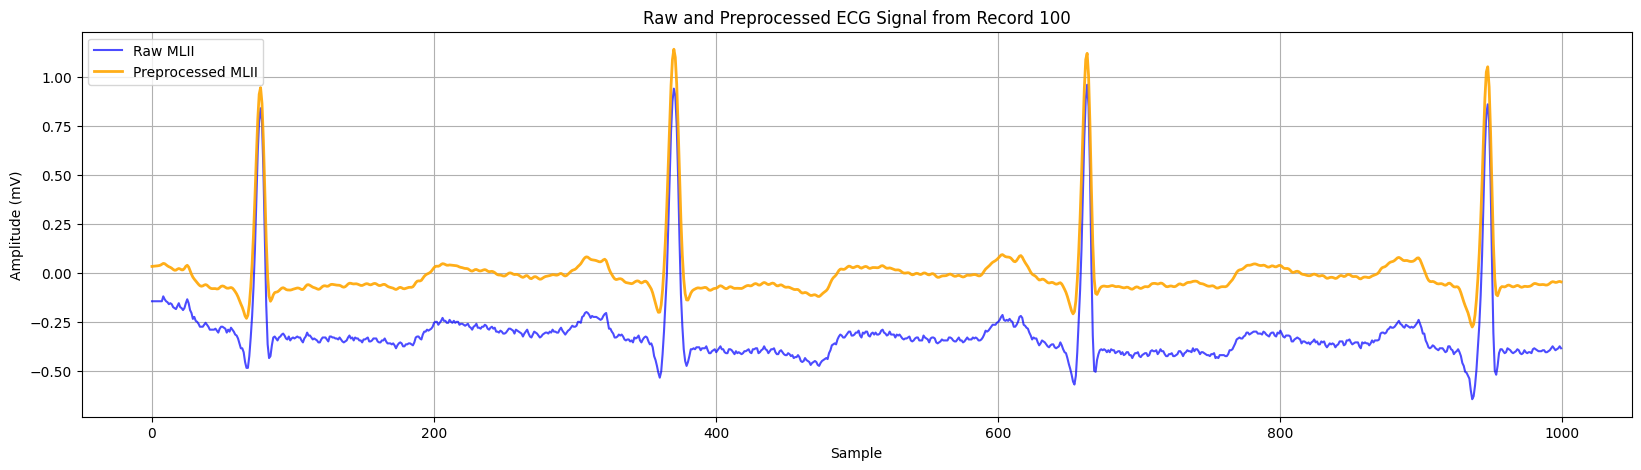

Mean: 0.00019719259936000496, Median: -0.026026031814096212, Std Dev: 0.17118791013984333, Variance: 0.02930530057804708


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt

# Load the signal from the CSV file
df_signals = pd.read_csv('/content/drive/MyDrive/ECG Analysis/CSV files/100_signals.csv')
ecg_signal = df_signals['MLII'].values


# Bandpass filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=1):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# High-pass filter function to correct baseline wandering
def highpass_filter(signal, cutoff, fs, order=1):
    nyquist = 0.5 * fs
    high = cutoff / nyquist
    b, a = butter(order, high, btype='high')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Apply bandpass filter to the ECG signal
lowcut = 0.5  # Lower cutoff frequency in Hz
highcut = 50.0  # Upper cutoff frequency in Hz
fs = 360  # Sampling frequency in Hz
filtered_signal = bandpass_filter(ecg_signal, lowcut, highcut, fs)

# Apply high-pass filter for baseline wandering correction
cutoff = 0.5  # Cutoff frequency in Hz
corrected_signal = highpass_filter(filtered_signal, cutoff, fs)



# Plot the raw and preprocessed signals on the same plot
plt.figure(figsize=(20, 5))
plt.plot(ecg_signal[:1000], label='Raw MLII', alpha=0.7, color='blue', linewidth=1.5)
plt.plot(corrected_signal[:1000], label='Preprocessed MLII', alpha=0.9, color='orange', linewidth=2)
plt.title('Raw and Preprocessed ECG Signal from Record 100')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ECG Analysis/Results/raw_and_preprocessed_signal.png')
plt.show()
plt.close()



# Calculate basic statistics for the preprocessed signal
mean_signal = np.mean(corrected_signal)
median_signal = np.median(corrected_signal)
std_signal = np.std(corrected_signal)
var_signal = np.var(corrected_signal)

print(f'Mean: {mean_signal}, Median: {median_signal}, Std Dev: {std_signal}, Variance: {var_signal}')


#ECG waves detection

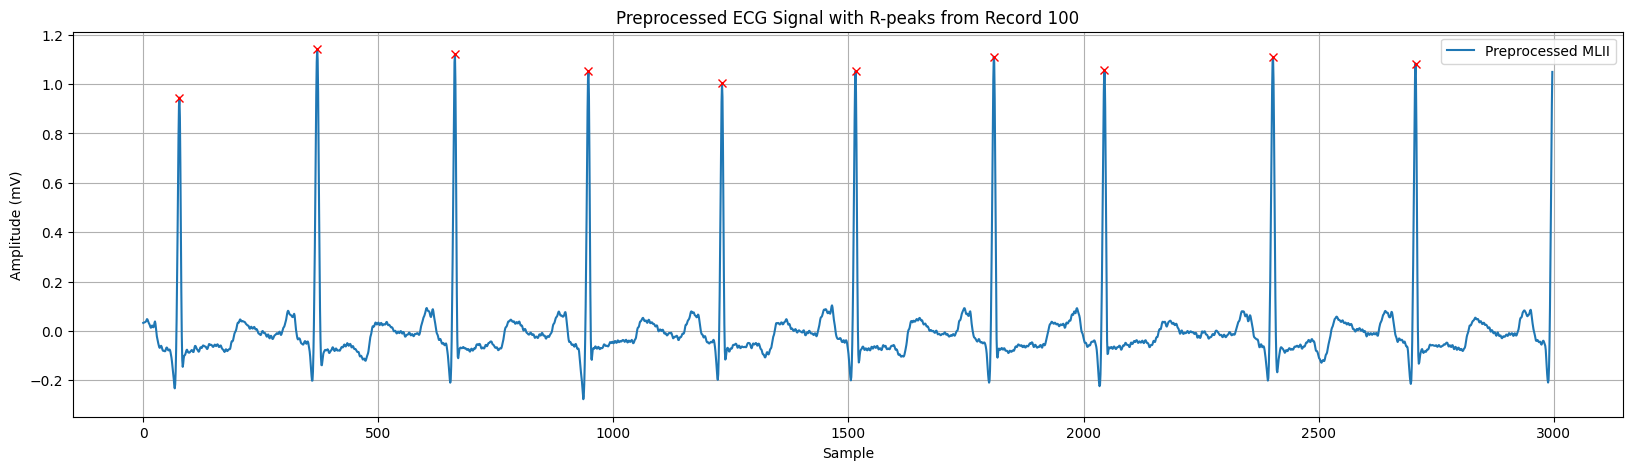

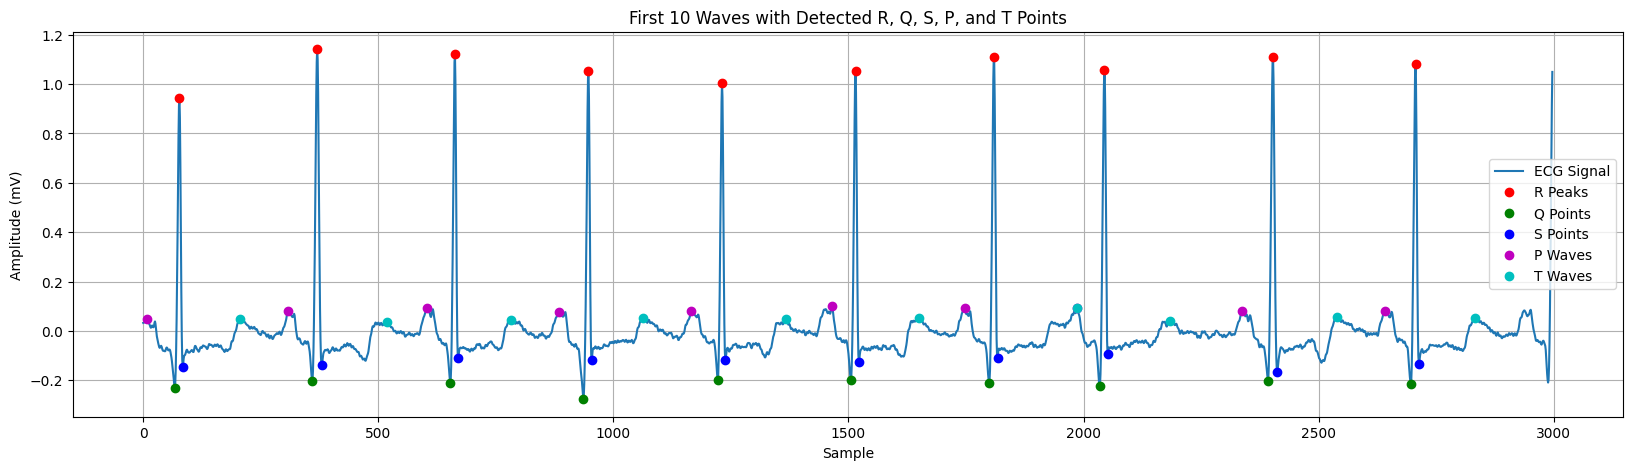

In [ ]:
# Detect R-peaks
r_peaks, _ = find_peaks(corrected_signal, distance=150, height=0.4)

# Plot the signal with detected R-peaks
plt.figure(figsize=(20, 5))
plt.plot(corrected_signal[:r_peaks[10]], label='Preprocessed MLII')
plt.plot(r_peaks[:10], corrected_signal[r_peaks][:10], 'rx')  # Plot first 10 peaks
plt.title('Preprocessed ECG Signal with R-peaks from Record 100')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ECG Analysis/Results/r_peaks_detection.png')
plt.show()
plt.close()


# Initialize arrays to hold the locations of Q, S, P, and T waves
q_locs = np.zeros(len(r_peaks), dtype=int)
s_locs = np.zeros(len(r_peaks), dtype=int)
p_locs = np.zeros(len(r_peaks), dtype=int)
t_locs = np.zeros(len(r_peaks), dtype=int)

# Q and S points detection
for i in range(len(r_peaks)):
    # Q point detection
    q_search_start = max(r_peaks[i] - 20, 0)
    q_search_end = r_peaks[i]
    q_locs[i] = q_search_start + np.argmin(corrected_signal[q_search_start:q_search_end])

    # S point detection
    s_search_start = r_peaks[i]
    s_search_end = min(r_peaks[i] + 20, len(corrected_signal) - 1)
    s_locs[i] = s_search_start + np.argmin(corrected_signal[s_search_start:s_search_end])

# P and T wave detection with improved intervals
for i in range(len(r_peaks)):
    # P wave detection
    p_search_start = max(r_peaks[i] - 200, 0)
    p_search_end = max(r_peaks[i] - 50, 0)
    if p_search_end > p_search_start:
        p_locs[i] = p_search_start + np.argmax(corrected_signal[p_search_start:p_search_end])
    else:
        p_locs[i] = r_peaks[i]

    # T wave detection
    t_search_start = min(r_peaks[i] + 50, len(corrected_signal) - 1)
    t_search_end = min(r_peaks[i] + 200, len(corrected_signal) - 1)
    if t_search_end > t_search_start:
        t_locs[i] = t_search_start + np.argmax(corrected_signal[t_search_start:t_search_end])
    else:
        t_locs[i] = r_peaks[i]

# Plot the signal with detected points
plt.figure(figsize=(20, 5))
plt.plot(corrected_signal[:r_peaks[10]], label='ECG Signal')
plt.plot(r_peaks[:10], corrected_signal[r_peaks[:10]], 'ro', label='R Peaks')
plt.plot(q_locs[:10], corrected_signal[q_locs[:10]], 'go', label='Q Points')
plt.plot(s_locs[:10], corrected_signal[s_locs[:10]], 'bo', label='S Points')
plt.plot(p_locs[:10], corrected_signal[p_locs[:10]], 'mo', label='P Waves')
plt.plot(t_locs[:10], corrected_signal[t_locs[:10]], 'co', label='T Waves')
plt.title('First 10 Waves with Detected R, Q, S, P, and T Points')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ECG Analysis/Results/wave_detection.png')
plt.show()
plt.close()

#Heart rate calculations

Mean RR Interval: 0.794593603286385, Std Dev of RR Intervals: 0.04809146326368222


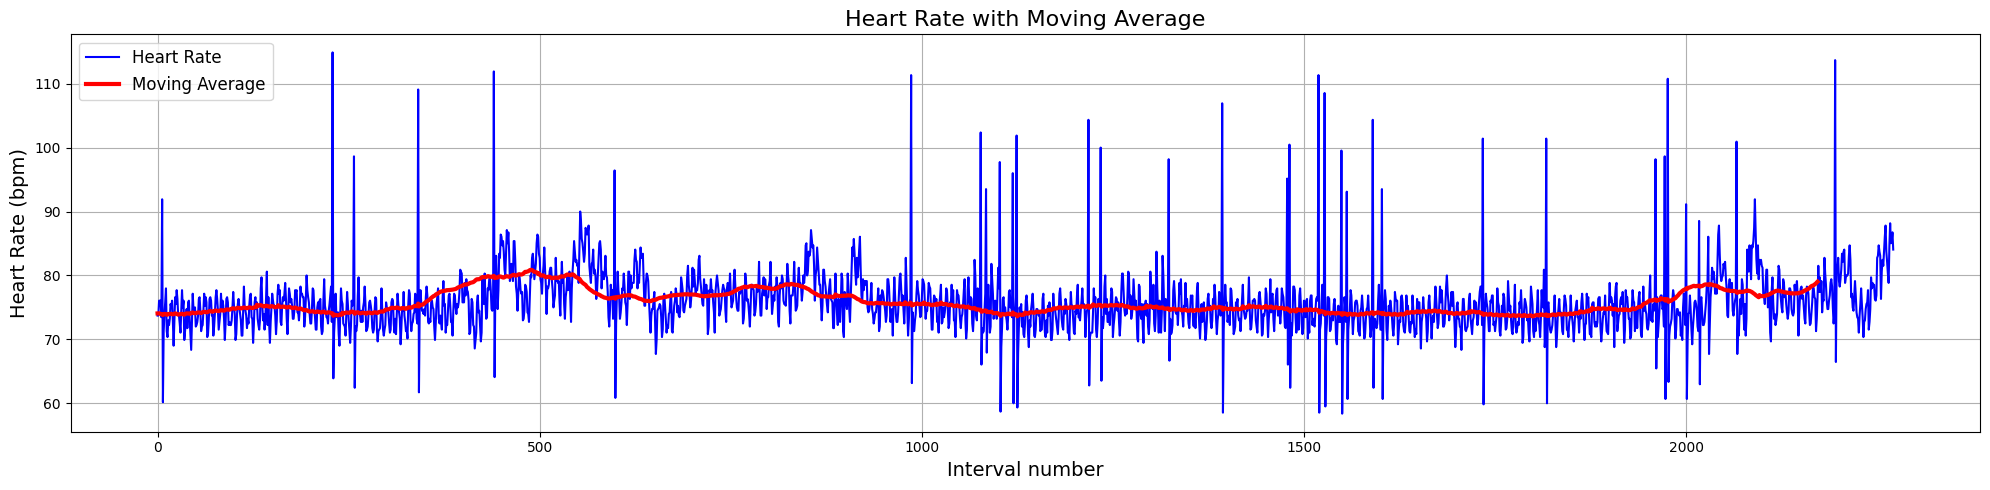

In [ ]:
# Calculate RR intervals (time between successive R-peaks)
rr_intervals = np.diff(r_peaks) / fs

# Calculate RR statistics
mean_rr = np.mean(rr_intervals)
std_rr = np.std(rr_intervals)
print(f'Mean RR Interval: {mean_rr}, Std Dev of RR Intervals: {std_rr}')

# Calculate Heart Rate (HR) as 60 / RR interval
heart_rate = 60 / rr_intervals


# Calculate the moving average of the heart rate
window_size = 100  # Adjust the window size as needed
moving_average_hr = np.convolve(heart_rate, np.ones(window_size)/window_size, mode='valid')

# Create an array for the x-axis for the moving average
x_moving_avg = np.arange(len(moving_average_hr))

# Plot the Heart Rate
plt.figure(figsize=(20, 5))
plt.plot(heart_rate[:5000], label='Heart Rate', color='blue', linewidth=1.5)  # Plot first 5000 heart rate values
plt.plot(x_moving_avg[:5000], moving_average_hr[:5000], label='Moving Average', color='red', linewidth=3)
plt.title('Heart Rate with Moving Average', fontsize=16)
plt.xlabel('Interval number', fontsize=14)
plt.ylabel('Heart Rate (bpm)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig('/content/drive/MyDrive/ECG Analysis/Results/heart_rate.png')
plt.show()
plt.close()



#Heart beat Visualization

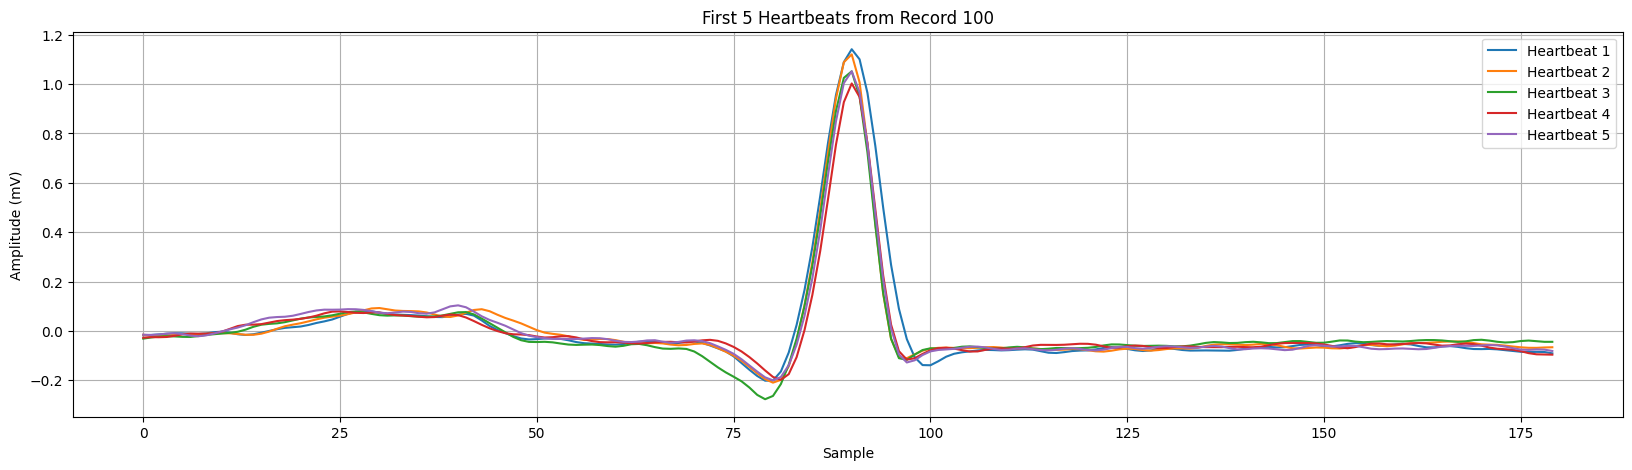

In [ ]:
# Define a function to segment ECG signal into individual heartbeats
def segment_ecg(signal, r_peaks, window=180):
    heartbeats = []
    for peak in r_peaks:
        start = peak - window // 2
        end = peak + window // 2
        if start >= 0 and end < len(signal):
            heartbeats.append(signal[start:end])
    return np.array(heartbeats)

# Segment the signal into heartbeats
window_size = 180  # Adjust based on the desired length of each heartbeat segment
heartbeats = segment_ecg(corrected_signal, r_peaks, window=window_size)

# Plot the first 5 heartbeats
plt.figure(figsize=(20, 5))
for i in range(5):
    plt.plot(heartbeats[i], label=f'Heartbeat {i+1}')
plt.title('First 5 Heartbeats from Record 100')
plt.xlabel('Sample')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid()
plt.savefig('/content/drive/MyDrive/ECG Analysis/Results/heartbeats.png')
plt.show()
plt.close()

#Waveform durations

Mean P wave duration: 0.1392 s
Mean QRS duration: 0.0507 s
Mean T wave duration: 0.3569 s


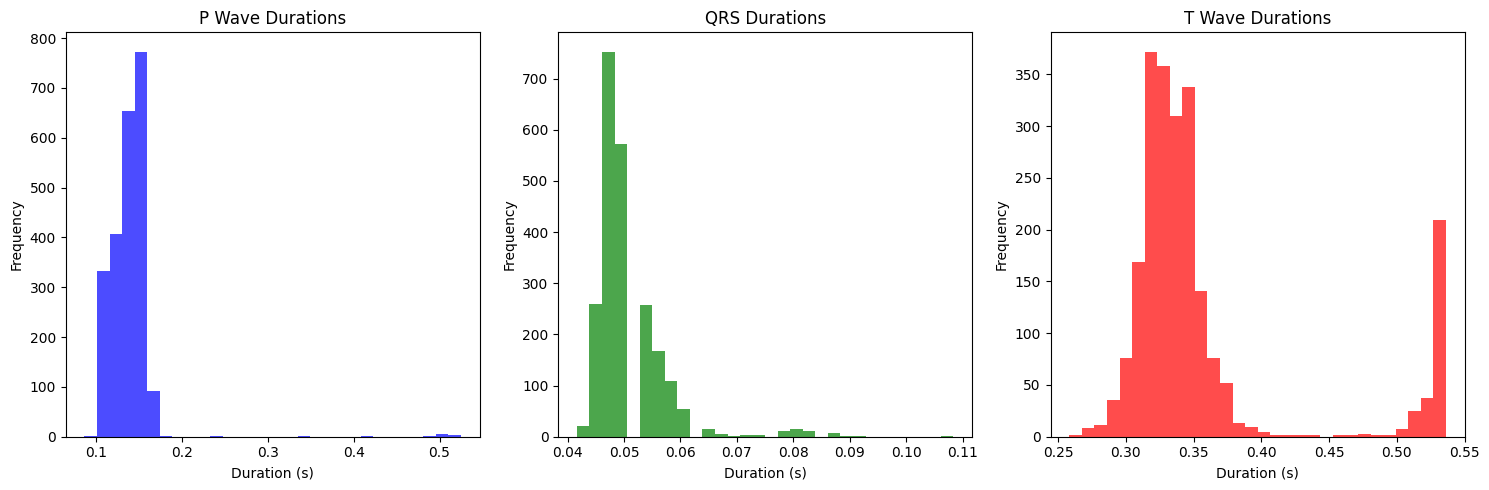

In [ ]:
# Calculate waveform durations

# Sampling frequency (Hz)
fs = 360

# Initialize lists to store durations
p_wave_durations = []
qrs_durations = []
t_wave_durations = []

# Calculate durations for each detected R peak
for i in range(len(r_peaks)):
    # Calculate P wave duration (P to Q interval)
    if q_locs[i] > p_locs[i]:
        p_wave_duration = (q_locs[i] - p_locs[i]) / fs
        p_wave_durations.append(p_wave_duration)

    # Calculate QRS duration (Q to S interval)
    if s_locs[i] > q_locs[i]:
        qrs_duration = (s_locs[i] - q_locs[i]) / fs
        qrs_durations.append(qrs_duration)

    # Calculate T wave duration (S to T interval)
    if t_locs[i] > s_locs[i]:
        t_wave_duration = (t_locs[i] - s_locs[i]) / fs
        t_wave_durations.append(t_wave_duration)

# Convert lists to numpy arrays for easier manipulation
p_wave_durations = np.array(p_wave_durations)
qrs_durations = np.array(qrs_durations)
t_wave_durations = np.array(t_wave_durations)

# Print the mean durations
print(f'Mean P wave duration: {np.mean(p_wave_durations):.4f} s')
print(f'Mean QRS duration: {np.mean(qrs_durations):.4f} s')
print(f'Mean T wave duration: {np.mean(t_wave_durations):.4f} s')

# Plot waveform durations
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.hist(p_wave_durations, bins=30, color='blue', alpha=0.7)
plt.title('P Wave Durations')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(qrs_durations, bins=30, color='green', alpha=0.7)
plt.title('QRS Durations')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.subplot(133)
plt.hist(t_wave_durations, bins=30, color='red', alpha=0.7)
plt.title('T Wave Durations')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ECG Analysis/Results/waveform_durations.png')
plt.show()
plt.close()